In [ ]:
from scipy.spatial import distance as dist
from imutils.video import VideoStream, FPS
from imutils import face_utils
import imutils
import numpy as np
import time
import dlib
import cv2

def smile(mouth):
    A = dist.euclidean(mouth[3], mouth[9])
    B = dist.euclidean(mouth[2], mouth[10])
    C = dist.euclidean(mouth[4], mouth[8])
    avg = (A+B+C)/3
    D = dist.euclidean(mouth[0], mouth[6])
    mar=avg/D
    return mar


COUNTER = 0
TOTAL = 0


shape_predictor= "../shape_predictor_68_face_landmarks.dat" #dace_landmark
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)


(mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]

print("[INFO] starting video stream thread...")
vs = VideoStream(src=0).start()
fileStream = False
time.sleep(1.0)

fps= FPS().start()
cv2.namedWindow("test")

while True:
    frame = vs.read()
    frame = imutils.resize(frame, width=450)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)
    for rect in rects:
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        mouth= shape[mStart:mEnd]
        mar= smile(mouth)
        mouthHull = cv2.convexHull(mouth)
        #print(shape)
        cv2.drawContours(frame, [mouthHull], -1, (0, 255, 0), 1)
       

        if mar <= .3 or mar > .38 :
            COUNTER += 1
        else:
            if COUNTER >= 15:
                TOTAL += 1
                frame = vs.read()
                time.sleep(.3)
                frame2= frame.copy()
                img_name = "opencv_frame_{}.png".format(TOTAL)
                cv2.imwrite(img_name, frame)
                print("{} written!".format(img_name))
            COUNTER = 0

        cv2.putText(frame, "MAR: {}".format(mar), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    cv2.imshow("Frame", frame)
    fps.update()

    key2 = cv2.waitKey(1) & 0xFF
    if key2 == ord('q'):
        break

fps.stop()


cv2.destroyAllWindows()
vs.stop()

In [ ]:
from concurrent.futures import thread
import enum
from threading import Thread
import cv2
import random
import time
from matplotlib import pyplot as plt

from paddle import save
import numpy as np

from tensorboard import summary

point = []
time_pt = []
clear = []

class analyzer_thread(Thread):
    def __init__(self, func, args=()):
        super(analyzer_thread, self).__init__() # 其实没见过这种写法
        self.func = func
        self.args = args

    def run(self):
        self.func(self.args)

class segment:
    def __init__(self, frames) -> None:
        self.frames = frames
        self.hogFeature = []
        self.clearFeature = []
        for fr in frames:
            self.hogFeature.append(getHogFeature(fr))
            self.clearFeature.append(getClearFeature(fr))
        self.hogFeature = np.array(self.hogFeature)
        self.clearFeature = np.array(self.clearFeature).var()

    def hog_dist(self, obj):
        return cv2.norm(self.hogFeature - obj.hogFeature, 2)
    
def getClearFeature(src):
    cal_img = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    canny = cv2.Canny(cal_img, 200, 200)
    return canny.var()

def getHogFeature(img:cv2.Mat, winSize=(64,128), blockSize=(16,16), blockStride=(8,8), cellSize=(8,8), nbins=9):
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
    cal_img = cv2.cvtColor(cv2.resize(img, winSize), cv2.COLOR_BGR2GRAY)
    hist = hog.compute(cal_img)
    return hist

def getSIFTFeature(img:cv2.Mat):

    pass

def initVideo(fps, path):
    cap = cv2.VideoCapture(path)
    # cap.set(5, fps)
    print(cap.get(cv2.CAP_PROP_FPS))
    print(cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(cap.get(cv2.CAP_PROP_FRAME_COUNT))

def getRand(fps, time, cap):
    summary_rand = []
    tot_frame = fps*time
    while True:
        ret, frame = cap.read()
        if ret == False: 
            break
        summary_rand.append(frame)
        if len(summary_rand) > tot_frame:
            randint = random.randint(0,tot_frame)
            summary_rand.pop(randint)
    return summary_rand

def saveVideo(summary, fps, size, type):
    t = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
    out = cv2.VideoWriter(f"video/{type}{t}.mp4", cv2.VideoWriter_fourcc('m','p','4','v'), fps, size, True)
    for fr in summary:
        out.write(cv2.resize(fr, size))
    out.release()

class hog_whole_dist:
    def __init__(self, cap, fps, time) -> None:
        self.summary = []
        self.cap = cap
        self.fps = fps
        self.time = time
        self.bestdist = None

    def HOG_whole_dist(self, now_segment:segment):
        if len(self.summary) < self.time:
        # 为了防止摘要什么都没有，开始的片段直接加进来
            self.summary.append(now_segment)
        else:
            if self.bestdist == None:
                self.bestdist = 0.0
                for i, seg in enumerate(self.summary):
                    for j in range(i+1, len(self.summary)):
                        self.bestdist+= seg.hog_dist(self.summary[j])
                        # print(f"init_dist:{seg.hog_dist(self.summary[j])}")
                self.bestdist /= self.time*(self.time-1)
            # 是否重复
            last = self.summary[len(self.summary)-1]
            testdist = now_segment.hog_dist(last)
            # print(f"test_dist:{testdist}")

            if testdist/2.0 < 2000.0:
                return 
            # 找替换后最好的
            k_frame = -1
            for k in range(len(self.summary)):
                tem_dist = 0.0
                for i in range(len(self.summary)):
                    for j in range(i+1, len(self.summary)):
                        if i == k:
                            tem_dist+=self.summary[j].hog_dist(now_segment)
                        elif j == k:
                            tem_dist+=self.summary[i].hog_dist(now_segment)
                        else:
                            tem_dist+=self.summary[i].hog_dist(self.summary[j])
                tem_dist /= self.time*(self.time-1)
                # print(f"segment:{k}, dist:{tem_dist}, best_dist:{self.bestdist}")
                if tem_dist > self.bestdist:
                    k_frame = k
                    self.bestdist = tem_dist
            # 替换
            if k_frame != -1:
                self.summary.pop(k_frame)
                self.summary.append(now_segment)

    def getSimple1(self):
        frame_cnt = 0
        tem_segment = []
        ana_cnt = 0
        analyze_thread = None
        front = None
        seg = None
        while True:
            ret, frame = self.cap.read()
            if ret == False: 
                break
            if analyze_thread!=None and analyze_thread.is_alive():
                print(f"drop frame!{ana_cnt}---{cv2.CAP_PROP_POS_FRAMES}")
                continue
            frame_cnt+=1
            tem_segment.append(frame)
            if frame_cnt % self.fps == 0:
                ana_cnt +=1
                front = seg 
                seg = segment(tem_segment.copy())
                analyze_thread = analyzer_thread(self.HOG_whole_dist, seg)
                analyze_thread.start()
                if frame_cnt != self.fps:
                    point.append(seg.hog_dist(front))
                    time_pt.append(cap.get(cv2.CAP_PROP_POS_MSEC)/1000.0)
                tem_segment.clear()
            
            if frame_cnt % 300 == 0:
                print(f"{frame_cnt}/{cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

        return self.summary

class hog_diff_dist:
    def __init__(self, cap, fps, time) -> None:
        self.summary = []
        self.cap = cap
        self.fps = fps
        self.time = time
        self.bestdist = None

    def HOG_diff_dist(self, now_segment:segment):
        if len(self.summary) < self.time:
        # 为了防止摘要什么都没有，开始的片段直接加进来
            self.summary.append(now_segment)
        else:
            if self.bestdist == None:
                self.bestdist = 0.0
                for i in range(len(self.summary-1)):
                    self.bestdist += self.summary[i].hog_dist(self.summary[i+1])
                self.bestdist /= (self.time-1)
            # 是否重复
            last = self.summary[len(self.summary)-1]
            testdist = now_segment.hog_dist(last)
            # print(f"test_dist:{testdist}")

            if testdist < self.bestdist:
                return 
            # 找替换后最好的
            k_frame = -1
            tem_dist = 100000000.0
            for k in range(len(self.summary)):
                t=0.0
                if k == 0:
                    t = self.summary[k].hog_dist(self.summary[k+1])
                elif k == len(self.summary)-1:
                    t = testdist+ self.summary[k].hog_dist(self.summary[k-1])
                    t -= self.summary[k-1].hog_dist(now_segment)
                else:
                    t = self.summary[k].hog_dist(self.summary[k-1])+self.summary[k].hog_dist(self.summary[k+1])
                    t-= self.summary[k-1].hog_dist(self.summary[k+1])
                if tem_dist < t:
                    k_frame = k
                    tem_dist = t   
            
            tem_dist+=testdist
            if tem_dist >= 0:
                self.bestdist+=tem_dist
            # 替换
                self.summary.pop(k_frame)
                self.summary.append(now_segment)

    def getSimple1(self):
        frame_cnt = 0
        tem_segment = []
        ana_cnt = 0
        analyze_thread = None
        front = None
        seg = None
        while True:
            ret, frame = self.cap.read()
            if ret == False: 
                break
            if analyze_thread!=None and analyze_thread.is_alive():
                print(f"drop frame!{ana_cnt}---{cv2.CAP_PROP_POS_FRAMES}")
                continue
            frame_cnt+=1
            tem_segment.append(frame)
            if frame_cnt % self.fps == 0:
                ana_cnt +=1
                front = seg 
                seg = segment(tem_segment.copy())
                analyze_thread = analyzer_thread(self.HOG_diff_dist, seg)
                analyze_thread.start()

                # debug
                clear.appent(seg.clearFeature)
                if frame_cnt != self.fps:
                    point.append(seg.hog_dist(front))
                    time_pt.append(cap.get(cv2.CAP_PROP_POS_MSEC)/1000.0)
                # end bug

                tem_segment.clear()
            
            if frame_cnt % 300 == 0:
                print(f"{frame_cnt}/{cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

        return self.summary




FPS = 15.0
TIME = 5
SIZE = (480,720)
PATH = "video/test.mp4"

cap = cv2.VideoCapture(PATH)

print("calculating")
ana = hog_whole_dist(cap, FPS, TIME)
summary = ana.getSimple1()


print("saving")
save = []
for s in summary:
    save.extend(s.frames)

saveVideo(save, FPS, SIZE, "hog_whole_dist")

print("closing...")
cap.release()


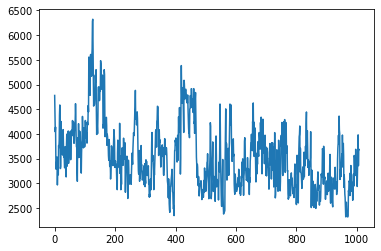

In [2]:
plt.plot(point)
plt.show()